In [2]:
import os, sys
import numpy as np
import uproot
import awkward as ak
import pandas as pd
from time import time

import pickle
import json

from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

In [3]:
def GausPDF(x, *c):
    A = c[0] # fraction of crystalball
    #define function parameters
    mu = c[1]
    sigma = c[2]
    z = (x-mu)/sigma
    G = A*(1/np.sqrt(2*(sigma**2)*np.pi))*np.exp(-(z**2)/2)
    return G

In [4]:
sys.path.append('/home/rusack/joshib/HGCALDRNElectron') # change this path to your own directory
from utils.pltutils import plt

In [5]:
def get_std_error(mu, sigma, N):
    A = [ np.random.normal(mu,sigma) for n in range(N) ]
    return np.mean(A)/len(A)

In [6]:
def get_estimated_std_error(sigma, N):
    f = np.exp(3.436)
    if N<=1: return sigma
    return sigma/(f**np.log10(N))

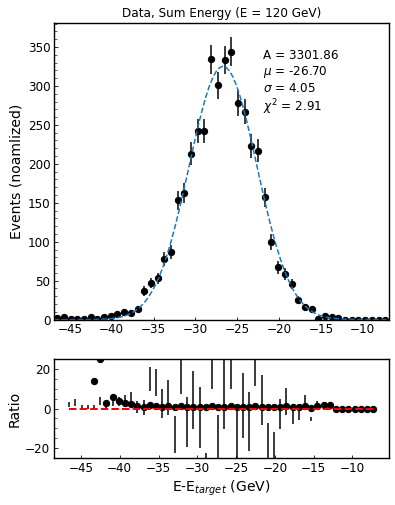

In [120]:
with open('data_sum_energy_120.pkl','rb') as f0:
    data_hist2_array = pickle.load(f0)

In [8]:
def fit_gaussian_res(xarray, earray, dtype, energy):
    yarray = earray
    mean_ = np.average(xarray, weights=yarray)
    std_ = np.sqrt(np.sum([w*(x-mean_)**2 for x,w in zip(xarray,yarray)])/len(earray))
    results = curve_fit(GausPDF, xarray, yarray, 
                    p0=(max(yarray), mean_, std_),
                    bounds=((0,-1e2,0),(1e3*max(yarray),1e3,1e3)))
    return results[0]

In [9]:
def generate_toys(bins, h, energy):
    rndm_pois = [ np.random.poisson(h) for i in range(1000) ]
    fit_params = [ fit_gaussian_res(bins, e, 'data', energy) for e in rndm_pois ]
    fit_params = np.array(fit_params)
    plt.clf()
    plt.figure(figsize=(4,4))
    A = fit_params[:,2]/(fit_params[:,1]+120)
    plt.hist(A, bins=50, range=(np.mean(A)-2*np.std(A), np.mean(A)+2*np.std(A)))
    plt.title('E = {}'.format(energy))
    plt.show()
    plt.close()
    return np.mean(A), np.std(A)

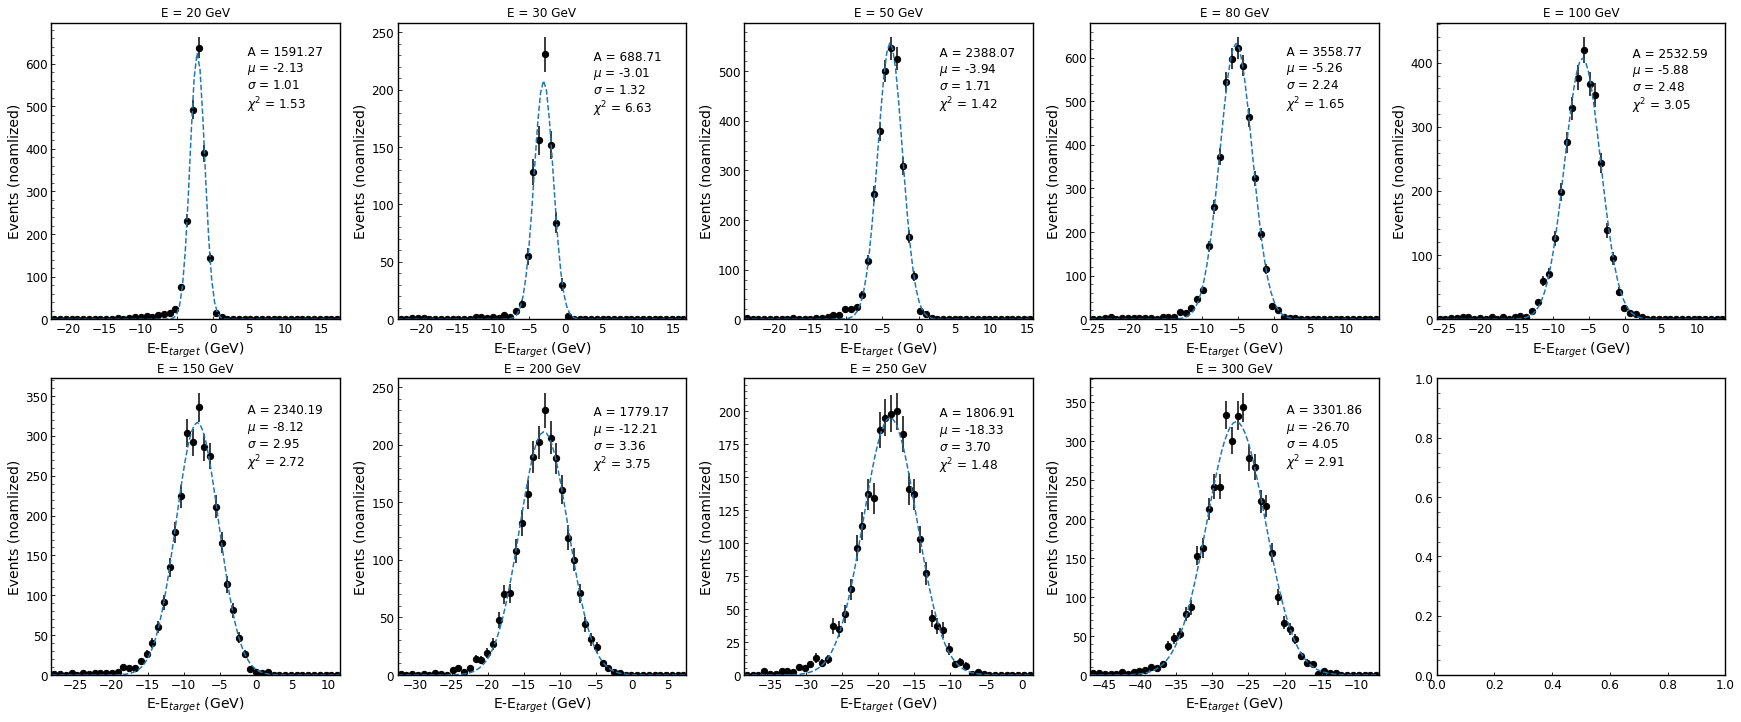

In [10]:
with open('plots/pkl/rechit_energy_sum_data.pkl','rb') as f0:
    hist_data_array = pickle.load(f0)

In [20]:
def get_cl(h, energy):    
    xarray = h.get_lines()[0].get_xdata()
    yarray = h.get_lines()[0].get_ydata()
    yerrarray = np.sqrt(yarray)
    mean_, std_ = generate_toys(xarray, yarray, energy)
    plt.savefig('plots/img/toys_mc_e_{}.png'.format(energy))
    return mean_, std_

In [12]:
energy_array = [20, 30, 50,80, 100, 150, 200, 250, 300]

In [17]:
h_array = hist_data_array.get_axes()[0:-1]

<Figure size 432x288 with 0 Axes>

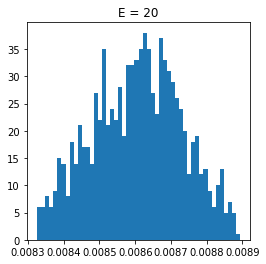

<Figure size 432x288 with 0 Axes>

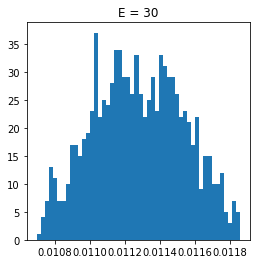

<Figure size 432x288 with 0 Axes>

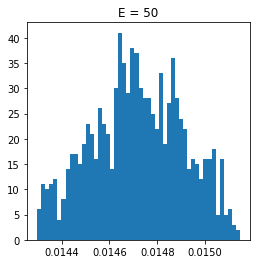

<Figure size 432x288 with 0 Axes>

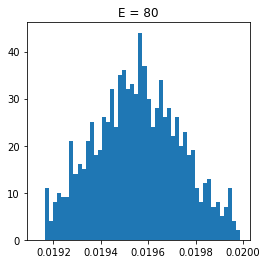

<Figure size 432x288 with 0 Axes>

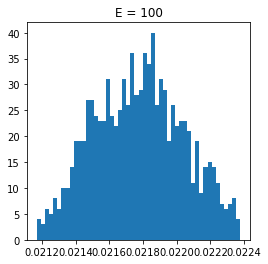

<Figure size 432x288 with 0 Axes>

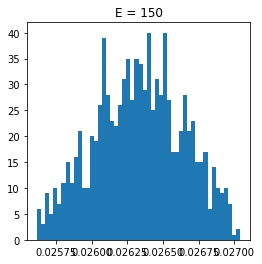

<Figure size 432x288 with 0 Axes>

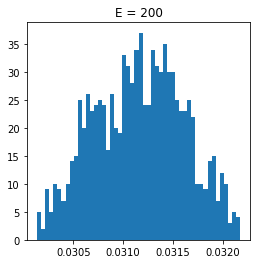

<Figure size 432x288 with 0 Axes>

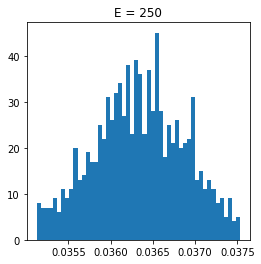

<Figure size 432x288 with 0 Axes>

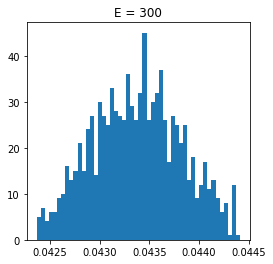

<Figure size 432x288 with 0 Axes>

In [22]:
cl_array = []
for e_,h_ in zip(energy_array, h_array):
    cl_array.append(np.array(get_cl(h_,e_)))

In [23]:
plt.clf()
plt.figure(figsize=(6.6,6.6))

mean_e = 1/np.sqrt(np.array([ e+fit_parameters['mc'][e][1] for e in fit_parameters['mc'] ]))
res_e = np.array([ res['mc_drn'][e] for e in res['mc_drn']])
plt.scatter(mean_e, res_e,
            marker='.', s=100, edgecolor='black', label='DRN',
            facecolor='w')
res_results_drn = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))

mean_e = 1/np.sqrt(np.array([ e for e in res['mc'] ]))
res_e = np.array([ res['mc'][e] for e in res['mc']])
plt.scatter(mean_e, res_e,
            marker='.', s=100, edgecolor='red', label='Sum',
            facecolor='w')
res_results_sum = curve_fit(Pol1PDF, xdata=mean_e, ydata=res_e,
         bounds = ((0,0), (1e3,1e3)), p0=(0.2, 0.02))


xarray = np.linspace(0.0, 0.55, 64)
yarray_mc_sum =  res_results_sum[0][0]*xarray+res_results_sum[0][1]
yarray_mc_drn = res_results_drn[0][0]*xarray+res_results_drn[0][1]

plt.plot(xarray, yarray_mc_sum, c='red', linestyle='--', label='S={:0.2f} %, C={:0.2f} %'.format(res_results_sum[0][0]*100, res_results_sum[0][1]*100))
plt.plot(xarray, yarray_mc_drn, c='black', linestyle='--', label='S={:0.2f} %, C={:0.2f} %'.format(res_results_drn[0][0]*100, res_results_drn[0][1]*100))

cms = plt.text(x=0.0, y=0.1, s="CMS $\it{Simuation}$",
    fontsize=18, fontweight='bold',
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')

slope_text= plt.text(x=0.0, y=0.035, s='')

plt.ylim(0.01, 0.1)
plt.xlim(0.0, 0.25)
plt.ylabel('$\sigma$(E)/<E>', size=14)
plt.xlabel('1/$\sqrt{E\ [GeV]}$', size=14)
plt.legend(fontsize=12, loc='upper left')
plt.show()

[array([0.00860941, 0.00014201]),
 array([0.01127782, 0.00028913]),
 array([0.01472189, 0.00021201]),
 array([0.01955865, 0.0002142 ]),
 array([0.02177357, 0.00030107]),
 array([0.02632835, 0.00035582]),
 array([0.03115481, 0.00050907]),
 array([0.03632936, 0.00060002]),
 array([0.04339106, 0.00051062])]